In [3]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GOOGLE_API_KEY")
_set_env("LANGSMITH_API_KEY")
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


In [17]:
from typing import List

from langchain_core.messages import SystemMessage
from langchain_google_genai import GoogleGenerativeAI
from langchain.chat_models import init_chat_model

from pydantic import BaseModel

In [20]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [22]:
# Generate Prompt 

from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

In [23]:
# Define the state logic 

from typing import Literal

from langgraph.graph import END


def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [24]:
# Create the graph 

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


memory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

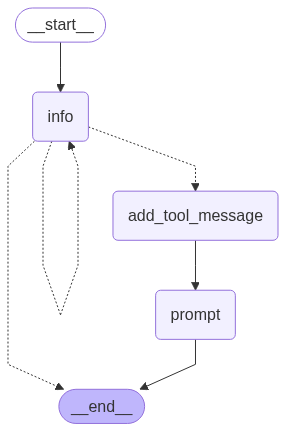

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
# Use the graph 

import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit):  Hi, want to create a prompt 


User (q/Q to quit): Hi, want to create a prompt 
================================== Ai Message ==================================

Great! To create the perfect prompt template, I need a little more information.  Tell me about:

1.  **The objective of the prompt:** What are we trying to achieve with this prompt? What should the LLM ultimately *do*?
2.  **Variables:** What information will be fed into the prompt as variables? (e.g., product name, customer review, article title, etc.)
3.  **Constraints:** Are there any things the LLM should *definitely NOT do* in its response?
4.  **Requirements:** Are there any specific requirements the output *must* adhere to? (e.g., be less than 280 characters, include a call to action, etc.)

Once I have these details, I can create the perfect prompt instructions!


User (q/Q to quit):  creating ai insights from given text


User (q/Q to quit): creating ai insights from given text
================================== Ai Message ==================================

Okay, that's a good start! To help me create the perfect prompt template, I still need a bit more information.

*   **Objective:** Besides creating AI insights, what is the main goal? What should these insights *do* or *achieve*? For example, are they meant to identify key themes, summarize the text, extract specific data points, or something else?
*   **Variables:** What kind of text will be fed into the prompt? (e.g., customer reviews, news articles, scientific papers, etc.)
*   **Constraints:** Are there any things the LLM should *definitely NOT do* in its response? For example, should it avoid making assumptions, refrain from providing subjective opinions, or stick to a specific format?
*   **Requirements:** Are there any specific requirements the output *must* adhere to? (e.g., be less than a certain length, include specific keywords, focus on 

User (q/Q to quit):  that ai insights will be used to create a journal what we call it smart journal


User (q/Q to quit): that ai insights will be used to create a journal what we call it smart journal
================================== Ai Message ==================================

Okay, great! So the AI insights will be used to create a "smart journal." I'm still trying to get a clear picture, so let's clarify a few things:

*   **Objective:** What is the primary goal of the AI insights *within the smart journal*? Are they meant to provide summaries, identify key themes, offer reflections, suggest actions, or something else? How will these insights be used by someone reading the journal?
*   **Variables:** What kind of text will be fed into the prompt? (e.g., personal reflections, meeting notes, research papers, etc.)
*   **Constraints:** What should the AI insights definitely *not* do? (e.g., offer unsolicited advice, make assumptions about the user's feelings, include information outside of the provided text, etc.)
*   **Requirements:** What specific requirements must the AI insigh

User (q/Q to quit):  voice input converted to text and that text in return is the smart insights


User (q/Q to quit): voice input converted to text and that text in return is the smart insights
================================== Ai Message ==================================

Okay, that helps a lot! So the input is voice converted to text (so, transcribed speech), and the goal is to generate smart insights from that text for a journal. Let's refine this further:

*   **Objective:** What kind of insights should the AI provide based on the transcribed speech? For example, should it identify key topics discussed, summarize action items, reflect on the user's feelings or intentions, or something else entirely? How will these insights be used *in the journal*?
*   **Constraints:** What should the AI *definitely NOT do* when generating insights? For example, should it avoid giving advice, making assumptions, or including information not present in the transcribed text? Should it avoid being overly negative or positive?
*   **Requirements:** What are the specific requirements for the AI in

User (q/Q to quit):  mostly the core points of the text, important notes form it etc


User (q/Q to quit): mostly the core points of the text, important notes form it etc
================================== Ai Message ==================================

Okay, so the objective is to extract core points and important notes from the transcribed speech.

*   **Objective:** To extract and summarize the core points and important notes from the transcribed speech, for use in a smart journal.

*   **Variables:** The transcribed speech text.

*   **Constraints:**
    *   The AI should not include information that is not present in the transcribed text.
    *   The AI should avoid making assumptions or offering personal opinions.
    *   The AI should not provide advice.

*   **Requirements:**
    *   The output should be concise and to-the-point.
    *   The output should focus on the most important information in the text.

Does that accurately summarize what you're looking for? If so, I can go ahead and create the prompt instructions.


User (q/Q to quit):  yes looks good


User (q/Q to quit): yes looks good
================================== Ai Message ==================================
Tool Calls:
  PromptInstructions (f4df1171-6583-4bc0-be42-3e6495f8c9a9)
 Call ID: f4df1171-6583-4bc0-be42-3e6495f8c9a9
  Args:
    requirements: ['The output should be concise and to-the-point.', 'The output should focus on the most important information in the text.']
    constraints: ['The AI should not include information that is not present in the transcribed text.', 'The AI should avoid making assumptions or offering personal opinions.', 'The AI should not provide advice.']
    objective: To extract and summarize the core points and important notes from the transcribed speech, for use in a smart journal.
    variables: ['The transcribed speech text.']
================================= Tool Message =================================

Prompt generated!


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents: contents is not specified
